<a href="https://colab.research.google.com/github/evanstaffen/Medical-Transcript-Classification/blob/main/word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, make_scorer, \
f1_score, precision_score, recall_score, accuracy_score, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB,MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors, Word2Vec

from keras.utils import pad_sequences
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import Adam

import pickle

In [2]:
!pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 118.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


In [4]:
with open('/content/drive/MyDrive/Medical Transcript Classification/Medical-Transcription-Classification copy/data/df.pickle', 'rb') as f:
    df = pickle.load(f)
df

,medical_specialty,transcription,transcript_gensim,gensim_cleaned
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit...","[mode, leave, atrial, enlargement, leave, atri...","[mode, leave, atrial, enlargement, leave, atri..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...,"[leave, ventricular, cavity, size, wall, thick...","[leave, ventricular, cavity, size, wall, thick..."
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart...","[echocardiogram, multiple, view, heart, great,...","[echocardiogram, multiple, view, heart, great,..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size....","[description, normal, cardiac, chamber, size, ...","[description, normal, cardiac, chamber, size, ..."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc...","[study, mild, aortic, stenosis, widely, calcif...","[study, mild, aortic, stenosis, widely, calcif..."
...,...,...,...,...
3709,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden...","[indication, chest, pain, type, test, adenosin...","[indication, chest, pain, type, test, adenosin..."
3710,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES...","[chief, complaint, chest, pain, history, prese...","[chief, complaint, chest, pain, history, prese..."
3711,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a...","[history, present, illness, patient, year, old...","[history, present, illness, patient, year, old..."
3712,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-...","[history, present, illness, mr, abc, year, old...","[history, present, illness, mr, abc, year, old..."


In [5]:
max_length = 0
lengths = []
for doc in df['gensim_cleaned']:
    lengths.append(len(doc))
    if len(doc) > max_length:
        max_length = len(doc)
max_length

1293

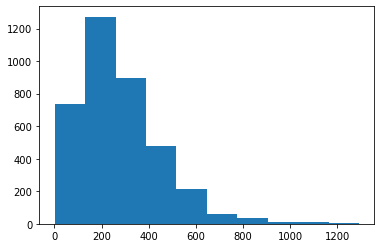

In [6]:
plt.hist(lengths);

# Train-test-split

In [7]:
X = df['gensim_cleaned']
y = df['medical_specialty']

X_train, X_testval, y_train, y_testval = train_test_split(
    X, y, test_size=0.3,random_state=42, stratify=y
    )

X_val, X_test, y_val, y_test = train_test_split(
    X_testval, y_testval, test_size=0.33, 
    random_state=42,stratify = y_testval
    )


In [8]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(2599,) (2599,)
(747,) (747,)
(368,) (368,)


In [9]:
display('Train', np.unique(y_train,return_counts=True))
display('Validation', np.unique(y_val,return_counts=True))
display('Test', np.unique(y_test,return_counts=True))

'Train'

(array(['Cardiovascular / Pulmonary',
        'Consult - History and Phy. / General Medicine',
        'Gastroenterology', 'Neurology / Neurosurgery',
        'Obstetrics / Gynecology', 'Orthopedic', 'Radiology', 'Surgery',
        'Urology'], dtype=object),
 array([260, 542, 157, 222, 109, 248, 191, 761, 109]))

'Validation'

(array(['Cardiovascular / Pulmonary',
        'Consult - History and Phy. / General Medicine',
        'Gastroenterology', 'Neurology / Neurosurgery',
        'Obstetrics / Gynecology', 'Orthopedic', 'Radiology', 'Surgery',
        'Urology'], dtype=object),
 array([ 74, 156,  45,  64,  31,  72,  55, 219,  31]))

'Test'

(array(['Cardiovascular / Pulmonary',
        'Consult - History and Phy. / General Medicine',
        'Gastroenterology', 'Neurology / Neurosurgery',
        'Obstetrics / Gynecology', 'Orthopedic', 'Radiology', 'Surgery',
        'Urology'], dtype=object),
 array([ 37,  77,  22,  31,  15,  35,  27, 108,  16]))

# LabelEncoder

In [10]:
le = LabelEncoder()
le.fit(y_train)
train_labels_encoded = le.transform(y_train)
val_labels_encoded = le.transform(y_val)
test_labels_encoded = le.transform(y_test)
num_classes = len(le.classes_)
mapping = dict(zip(range(len(le.classes_)), le.classes_))

# Trying class-weights but made model much worse

In [11]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(train_labels_encoded), 
                                                  y = train_labels_encoded)
class_weights = dict(zip(np.unique(train_labels_encoded),class_weights))
class_weights

{0: 1.1106837606837607,
 1: 0.53280032800328,
 2: 1.8393489030431707,
 3: 1.3008008008008007,
 4: 2.6493374108053005,
 5: 1.164426523297491,
 6: 1.5119255381035486,
 7: 0.3794714556869616,
 8: 2.6493374108053005}

# Preprocessing

In [12]:
embedding_size = 100
word2vec_model = Word2Vec(X_train, size=embedding_size, min_count=1)

# needed to add this because some words in test and val data do not appear in training data
# all the more reason to use one of the fancy pre-trained GloVe vectors
default_vec = np.zeros(embedding_size)

# don't think the double list comprehension is necessary for train_sequences
train_sequences = [[word2vec_model.wv[d] if d in word2vec_model.wv else default_vec for d in doc] for doc in X_train]
val_sequences = [[word2vec_model.wv[d] if d in word2vec_model.wv else default_vec for d in doc] for doc in X_val]
test_sequences = [[word2vec_model.wv[d] if d in word2vec_model.wv else default_vec for d in doc] for doc in X_test]

In [13]:
max_length = 1293
train_sequences = pad_sequences(train_sequences, maxlen=max_length,
                                padding='post',dtype='float32')
val_sequences = pad_sequences(val_sequences, maxlen=max_length,
                              padding='post',dtype='float32')
test_sequences = pad_sequences(test_sequences, maxlen=max_length, 
                               padding='post',dtype='float32')

In [ ]:
train_sequences[0]

array([[-0.5233127 ,  0.09552618,  0.7826219 , ...,  0.07290368,
         0.18963532,  0.05835712],
       [ 0.30308047, -0.4078998 ,  0.9758383 , ..., -0.27660814,
         0.48263106,  0.6033549 ],
       [ 0.34111372, -0.08266104,  1.0108256 , ..., -0.62030214,
         0.53134644,  0.2963374 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [19]:
train_sequences.shape,train_labels_encoded.shape

((2599, 1293, 100), (2599,))

# Functions

In [14]:
def evaluate_model(model):
  predictions = model.predict(test_sequences)
  predicted_max = np.argmax(predictions, axis=1)

  predicted_labels = le.inverse_transform(predicted_max)
  test_labels_decoded = le.inverse_transform(test_labels_encoded)

  acc_te = accuracy_score(test_labels_decoded,predicted_labels)
  precision_te,recall_te,f1_te,_ = precision_recall_fscore_support(test_labels_decoded,
                                  predicted_labels,average='weighted',zero_division = 0)
  print('Test Accuracy: ', acc_te)
  print('Test Precision: ', precision_te)
  print('Test Recall: ', recall_te)
  print('Test F1: ', f1_te)

  conf_matrix = confusion_matrix(test_labels_decoded,predicted_labels)
  sns.heatmap(conf_matrix,annot=True,fmt='d',
              xticklabels=mapping.values(),
              yticklabels=mapping.values()
  );

In [15]:
def plot_history(results):
  history = results.history
  plt.figure() 
  plt.plot(history['val_loss']) 
  plt.plot(history['loss']) 
  plt.legend(['val_loss', 'loss']) 
  plt.title('Loss') 
  plt.xlabel('Epochs') 
  plt.ylabel('Loss')
  plt.show()

  plt.figure()
  plt.plot(history['val_accuracy'])
  plt.plot(history['accuracy'])
  plt.legend(['val_accuracy', 'accuracy'])
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.show()

# First Model

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(max_length, embedding_size), dropout=0.2, 
               recurrent_dropout=0.2,return_sequences=True,
               activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,
               activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max',
                               restore_best_weights=True, min_delta=1e-4)

In [ ]:
results = model.fit(train_sequences, pd.get_dummies(train_labels_encoded), 
                    epochs=25, batch_size=128, 
          validation_data=[val_sequences,pd.get_dummies(val_labels_encoded)],
          callbacks=[early_stopping]#,class_weight=class_weights
          )


Epoch 1/25
21/21 [==============================] - 408s 19s/step - loss: nan - accuracy: 0.1651 - val_loss: nan - val_accuracy: 0.0991
Epoch 2/25
21/21 [==============================] - 399s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 3/25
21/21 [==============================] - 395s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 4/25
21/21 [==============================] - 399s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 5/25
21/21 [==============================] - 402s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 6/25
21/21 [==============================] - 399s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991


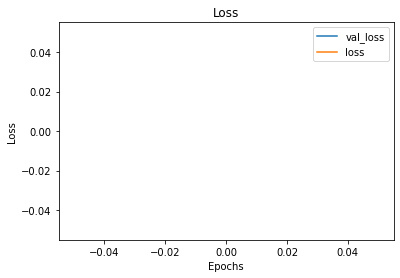

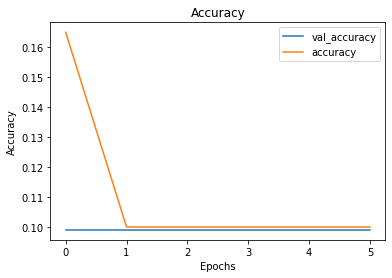

In [ ]:
plot_history(results)

12/12 [==============================] - 11s 906ms/step
Test Accuracy:  0.10054347826086957
Test Precision:  0.010108991020793951
Test Recall:  0.10054347826086957
Test F1:  0.01837090713902308


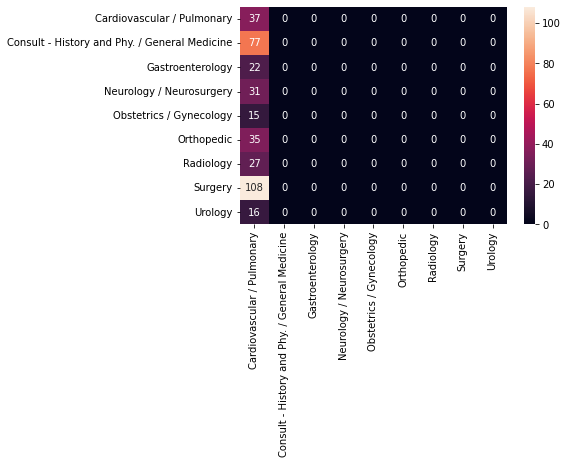

In [ ]:
evaluate_model(model)

# Second Model

### Changing activation fxn

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(128, input_shape=(max_length, embedding_size), dropout=0.2, 
               recurrent_dropout=0.2,return_sequences=True,
               activation='tanh'))
model_2.add(Dropout(0.2))
model_2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,
               activation='tanh'))
model_2.add(Dense(num_classes, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max',
                               restore_best_weights=True, min_delta=1e-4)

In [ ]:
results_2 = model_2.fit(train_sequences, pd.get_dummies(train_labels_encoded), epochs=25, batch_size=128, 
          validation_data=[val_sequences,pd.get_dummies(val_labels_encoded)],
          callbacks=[early_stopping]#,class_weight=class_weights
          )


Epoch 1/25
21/21 [==============================] - 408s 19s/step - loss: 2.0716 - accuracy: 0.2859 - val_loss: 1.9794 - val_accuracy: 0.2932
Epoch 2/25
21/21 [==============================] - 395s 19s/step - loss: 1.9819 - accuracy: 0.2928 - val_loss: 1.9785 - val_accuracy: 0.2932
Epoch 3/25
21/21 [==============================] - 397s 19s/step - loss: 1.9809 - accuracy: 0.2932 - val_loss: 1.9795 - val_accuracy: 0.2932
Epoch 4/25
21/21 [==============================] - 400s 19s/step - loss: 1.9815 - accuracy: 0.2932 - val_loss: 1.9782 - val_accuracy: 0.2932
Epoch 5/25
21/21 [==============================] - 399s 19s/step - loss: 1.9825 - accuracy: 0.2932 - val_loss: 1.9786 - val_accuracy: 0.2932
Epoch 6/25
21/21 [==============================] - 399s 19s/step - loss: 1.9833 - accuracy: 0.2932 - val_loss: 1.9794 - val_accuracy: 0.2932


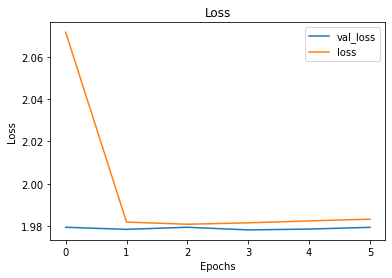

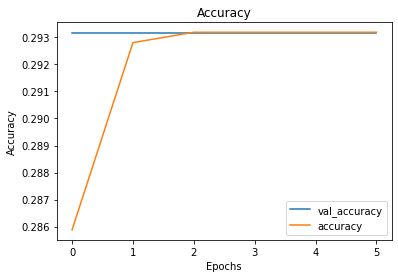

In [ ]:
plot_history(results_2)

12/12 [==============================] - 12s 957ms/step
Test Accuracy:  0.29347826086956524
Test Precision:  0.08612948960302458
Test Recall:  0.29347826086956524
Test F1:  0.13317500913408842


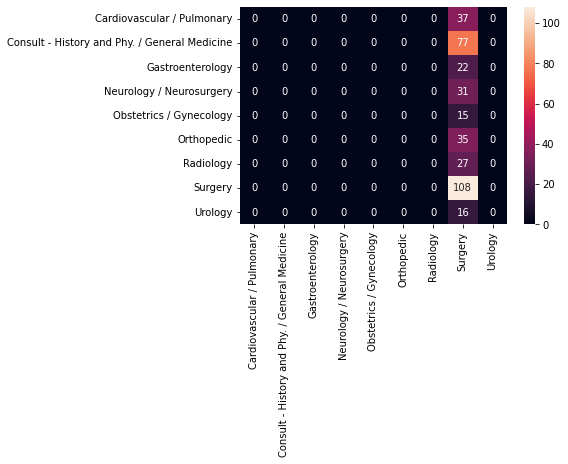

In [ ]:
evaluate_model(model_2)

# Third Model

### Adding l2 reg

In [ ]:
model_3 = Sequential()
model_3.add(LSTM(128, input_shape=(max_length, embedding_size),
          dropout=0.2, recurrent_dropout=0.2,
          return_sequences=True, activation='tanh',
          kernel_regularizer=regularizers.l2(0.01)))
model_3.add(Dropout(0.2))
model_3.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,
          activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model_3.add(Dense(num_classes, activation='softmax'))

model_3.compile(loss='categorical_crossentropy', optimizer='adam',
          metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max',
                               restore_best_weights=True, min_delta=1e-4)

In [ ]:
results_3 = model_3.fit(train_sequences, pd.get_dummies(train_labels_encoded), 
          epochs=25, batch_size=128, 
          validation_data=[val_sequences,pd.get_dummies(val_labels_encoded)],
          class_weight=class_weights, callbacks=[early_stopping]
          )


Epoch 1/25
21/21 [==============================] - 419s 19s/step - loss: 4.7966 - accuracy: 0.0677 - val_loss: 4.0196 - val_accuracy: 0.0415
Epoch 2/25
21/21 [==============================] - 426s 20s/step - loss: 3.5634 - accuracy: 0.0927 - val_loss: 3.1235 - val_accuracy: 0.0857
Epoch 3/25
21/21 [==============================] - 410s 20s/step - loss: 2.8753 - accuracy: 0.0958 - val_loss: 2.6432 - val_accuracy: 0.0991
Epoch 4/25
21/21 [==============================] - 401s 19s/step - loss: 2.5191 - accuracy: 0.1274 - val_loss: 2.4006 - val_accuracy: 0.2932
Epoch 5/25
21/21 [==============================] - 409s 19s/step - loss: 2.3438 - accuracy: 0.0877 - val_loss: 2.2884 - val_accuracy: 0.0736
Epoch 6/25
21/21 [==============================] - 409s 19s/step - loss: 2.2615 - accuracy: 0.1266 - val_loss: 2.2349 - val_accuracy: 0.0857
Epoch 7/25
21/21 [==============================] - 406s 19s/step - loss: 2.2243 - accuracy: 0.0758 - val_loss: 2.2141 - val_accuracy: 0.0964
Epoch 

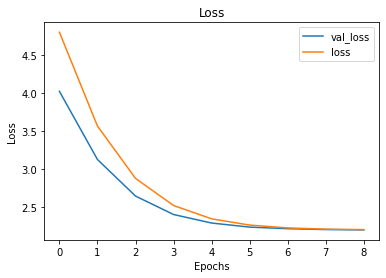

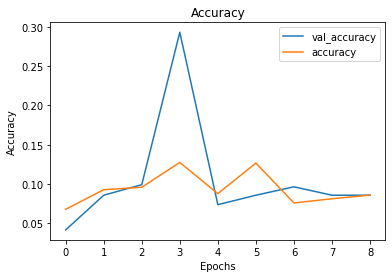

In [ ]:
plot_history(results_3)

12/12 [==============================] - 15s 1s/step
Test Accuracy:  0.29347826086956524
Test Precision:  0.08636417486079849
Test Recall:  0.29347826086956524
Test F1:  0.13345537757437073


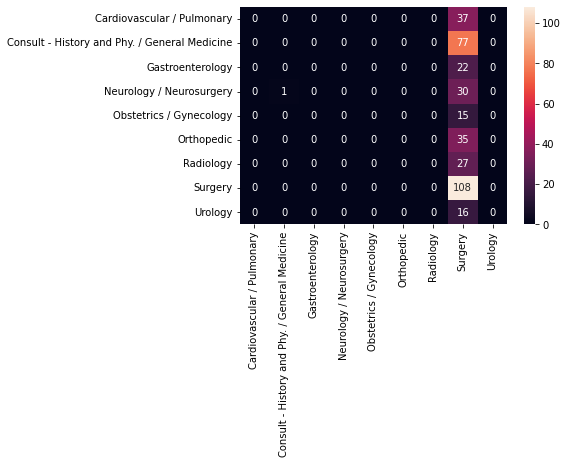

In [ ]:
evaluate_model(model_3)

# Fourth Model

In [ ]:

model_4 = Sequential()
model_4.add(LSTM(128, input_shape=(max_length, embedding_size),
          dropout=0.2, recurrent_dropout=0.2,
          return_sequences=True, activation='tanh',
          kernel_regularizer=regularizers.l2(0.01)))
model_4.add(Dropout(0.2))
model_4.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,
          activation='tanh', kernel_regularizer=regularizers.l2(0.01)))
model_4.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.1)

model_4.compile(loss='categorical_crossentropy', optimizer=adam,
          metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max',
                               restore_best_weights=True, min_delta=1e-4)


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
results_4 = model_4.fit(train_sequences, pd.get_dummies(train_labels_encoded), 
          epochs=25, batch_size=128, 
          validation_data=[val_sequences,pd.get_dummies(val_labels_encoded)],
          class_weight=class_weights, callbacks=[early_stopping]
          )


Epoch 1/25
21/21 [==============================] - 419s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 2/25
21/21 [==============================] - 395s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 3/25
21/21 [==============================] - 390s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 4/25
21/21 [==============================] - 389s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 5/25
21/21 [==============================] - 390s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991
Epoch 6/25
21/21 [==============================] - 389s 19s/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.0991


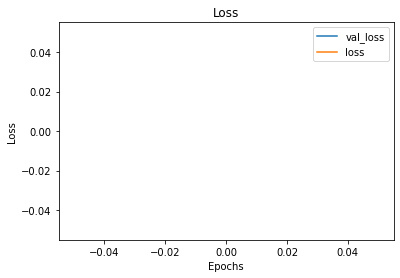

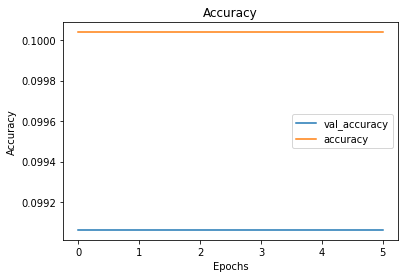

In [ ]:
plot_history(results_4)

12/12 [==============================] - 12s 923ms/step
Test Accuracy:  0.10054347826086957
Test Precision:  0.010108991020793951
Test Recall:  0.10054347826086957
Test F1:  0.01837090713902308


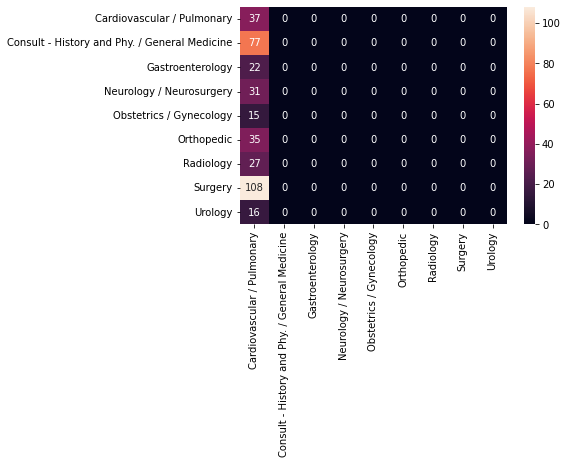

In [ ]:
evaluate_model(model_4)